In [1]:
import requests
import bs4
import os
import re
import unicodedata
import pandas as pd
import nltk
import prepare

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import user, password, host
import utilities

# 1. Spam Data

### a. Load the spam data set. 

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [3]:
def counts_and_ratios(df, column):
    '''
    Description:
    -----------
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    
    Parameters:
    ----------
    df: Dataframe
        Dataframe being explored
    column: str
        Columns should be a categorical or binary column.
    '''
    labels = pd.concat([df[column].value_counts(),
                   df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'pct']
    
    return labels

In [4]:
counts_and_ratios(df, 'label')

,n,pct
ham,4825,0.865937
spam,747,0.134063


In [34]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt', r'[a-z]']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [35]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [7]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [8]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [9]:
word_counts.sort_values(by='spam', ascending=False).head(10)

,all,ham,spam
call,600,241,359
free,275,59,216
txt,163,13,150
ur,384,240,144
text,214,77,137
mobile,150,15,135
4,287,168,119
claim,115,0,115
stop,153,40,113
reply,145,43,102


In [10]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(10),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(10)])

,all,ham,spam
didnt,79,79,0
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0


38142

In [54]:
from wordcloud import WordCloud

In [89]:
ham_string = ' '.join(ham_words)

In [90]:
ham_string = re.sub(r'[\s]+', ' ', ham_string)

(-0.5, 399.5, 199.5, -0.5)

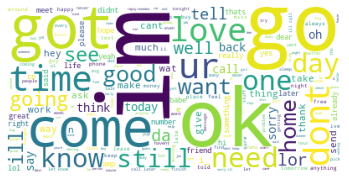

In [91]:
img = WordCloud(background_color='white').generate(ham_string)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

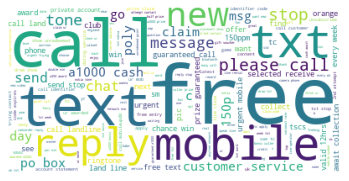

In [92]:
spam_string = ' '.join(spam_words)
spam_string = re.sub(r'[\s]+', ' ', spam_string)

img = WordCloud(background_color='white').generate(spam_string)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

In [110]:
bigrams = nltk.ngrams(spam_string.split(), 2)
trigrams = nltk.ngrams(spam_string.split(), 3)

In [111]:
top_20_spam_bigrams = (pd.Series(bigrams).value_counts().head(20))

top_20_spam_bigrams.head(20)

(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(send, stop)            19
(chance, win)           19
(every, week)           19
(selected, receive)     19
(await, collection)     19
(urgent, mobile)        18
(land, line)            18
(valid, 12hrs)          17
(claim, call)           17
(account, statement)    16
(sae, tc)               16
(prize, claim)          16
(call, 08000930705)     16
(reply, call)           15
dtype: int64

In [112]:
top_20_spam_trigrams = (pd.Series(trigrams).value_counts().head(20))

top_20_spam_trigrams.head(20)

(prize, guaranteed, call)              21
(call, customer, service)              15
(land, line, claim)                    14
(reply, call, 08000930705)             14
(2003, account, statement)             13
(private, 2003, account)               13
(guaranteed, a1000, cash)              12
(show, 800, unredeemed)                12
(camcorder, reply, call)               12
(urgent, trying, contact)              11
(every, week, txt)                     11
(anytime, network, min)                11
(please, call, customer)               11
(bonus, caller, prize)                 11
(tone, 4, ur)                          11
(customer, service, representative)    10
(speak, live, operator)                10
(a2000, bonus, caller)                 10
(cash, await, collection)              10
(contact, today, draw)                  9
dtype: int64

### c. Is there any overlap in the bigrams for the spam data and the ham data?

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

# 2. Explore the blog articles using the techniques discussed in the exploration lesson.



In [68]:
codeup = pd.read_csv('codeup_blogs.csv')
codeup.drop(columns=['Unnamed: 0'], inplace=True)
codeup.head()

,title,body
0,The Best Path to a Career in Data Science,"In our blog, “The Best Path To A Career In Sof..."
1,"Hey Dallas, Meet Your Software Development Men...","We may be new to town here in Dallas, but Code..."
2,5 Tools Every Programmer Should Use,5 Tools Every Programmer Should Use\nEvery tra...
3,How I Went From Codeup to Business Owner,"Out of college, I was a bit of a mess. That’s ..."
4,How Codeup Paid Off for Both Employee and Empl...,"After graduating from Codeup in 2016, Stan H. ..."


In [71]:
codeup['lemmed_body'] = ([prepare.clean_lem_stop(string) for string in codeup.body])

In [77]:
codeup.head()

,title,body,lemmed_body
0,The Best Path to a Career in Data Science,"In our blog, “The Best Path To A Career In Sof...",blog best path career software development loo...
1,"Hey Dallas, Meet Your Software Development Men...","We may be new to town here in Dallas, but Code...",may new town dallas codeup ha long history tra...
2,5 Tools Every Programmer Should Use,5 Tools Every Programmer Should Use\nEvery tra...,5 tool every programmer useevery trade ha tool...
3,How I Went From Codeup to Business Owner,"Out of college, I was a bit of a mess. That’s ...",college wa bit mess thats would told anyway su...
4,How Codeup Paid Off for Both Employee and Empl...,"After graduating from Codeup in 2016, Stan H. ...",graduating codeup 2016 stan h wa hired digital...


In [98]:
blog_words = ' '.join(codeup.lemmed_body)

In [104]:
blog_words.value_counts()

AttributeError: 'str' object has no attribute 'value_counts'

# 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring. 

In [72]:
categories = ['india',
'business',
'sports',
'world',
'politics',
'technology',
'startup',
'entertainment',
'miscellaneous',
'hatke',
'science',
'automobile']

In [73]:
def inshorts_articles(article, cat):
    return {
        'title': article.find(itemprop="headline").text,
        'body': article.find(itemprop="articleBody").text,
        'author': article.find(class_="author").text,
        'date_modified': article.find(clas="date").text,
        'time_modified': article.find(class_="time").text,
        'category': cat,
    }


def get_inshorts_articles(categories):
    
    inshort_df = pd.DataFrame(columns=['title', 'body','author','date_modified','time_modified'])
    base_url = 'https://inshorts.com/en/read/'
    
    for cat in categories:
        url = str(base_url + cat)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        response = requests.get(url, headers=headers)
        html = response.text
        soup = bs4.BeautifulSoup(html)
        container = soup.select('.card-stack')[0]
        articles = container.select('.news-card.z-depth-1')
        article = articles[0]
        
        # converts dictionary into a dataframe
        article_df = pd.DataFrame([inshorts_articles(article, cat) for article in articles])
    
        # concats the container_df to the blog_df created earlier
        inshort_df = pd.concat([inshort_df, article_df], axis=0)
    
    return inshort_df.reset_index(drop=True)

In [74]:
news = get_inshorts_articles(categories)

In [75]:
news.head(1)

,title,body,author,date_modified,time_modified,category
0,Oldest woman in India passes away,"Kunjannam, a 112-yr-old woman from Parannur (K...",Shipra Sharma,"24 Mar 2015,Tuesday",02:33 pm,india


In [76]:
counts_and_ratios(news, 'category')

,n,pct
sports,25,0.088652
world,25,0.088652
entertainment,25,0.088652
technology,25,0.088652
business,25,0.088652
politics,25,0.088652
miscellaneous,25,0.088652
science,24,0.085106
startup,24,0.085106
automobile,24,0.085106
